# Multinomial Model

Consider a simple model where we observe $X_1,\dots,X_n \overset{iid}{\sim} \text{Mult}(p)$ where $p\in\Delta^{K-1}$. The parameter of interest is $p$ and we endow it with a Dirichlet prior, so $\pi(p) \propto p_1^{\gamma-1}\cdots p_K^{\gamma-1}$ for $(p_1,\dots,p_K)\in\Delta^{K-1}$. The likelihood for the model is 

$$\mathcal{L}(p;X) = \prod_{i=1}^n \prod_{j=1}^K p_j^{\boldsymbol{1}(X_i = j)} = \prod_{j=1}^K p_j^{n_j}$$

where $n_j=\sum_i \boldsymbol{1}(X_i=j)$ is the number of occurences of $j$ in the data. Clearly, this is a conjugate family with the posterior being Dirichlet with parameters $(\gamma+n_1,\dots,\gamma+n_K)$. However we wish to use Metropolis Adjusted Langevin Algorithm for inference.

The target posterior has the form $\pi(p|X) \propto \prod_{j=1}^K p_j^{\gamma+n_j-1}$ if $p\in\Delta^{K-1}$ and 0 otherwise, and hence the target potential is
$$U(p) = \log \pi(p|X) = \sum_{j=1}^K (\gamma+n_j-1) \log p_j$$
with gradient given by 
$$\nabla U(p) = \left(\frac{\gamma+n_1-1}{p_1}, \frac{\gamma+n_2-1}{p_2}, \dots, \frac{\gamma+n_K-1}{p_K}\right)^\top.$$

MALA takes the following: Initialize $p^{(0)}$. For $t=0,1,2\dots$
1. Langevin gradient step: $q^{(t+1)} = p^{(t)} + \epsilon_t \nabla U(p^{(t)})$
2. Projection to simplex: $\tilde{q}^{(t+1)} = P_{\Delta^{K-1}} (q^{(t+1)})$
3. Proposal with Gaussian perturbation: $\tilde{p}^{(t+1)} = P_{A}(\tilde{q}^{(t+1)} + \sqrt{2\epsilon_t} \xi)$ where $\xi\sim N_K(0,I)$ and $P_A$ is the projection on the affine hull of $\Delta^{K-1}$ (this accounts to adding a $(K-1)$-dim Gaussian noise on that particular affine space.
4. Compute the Hastings ratio: 
$$r = \min \left\{1, \frac{\pi(\tilde{p}^{(t+1)})q(p^{(t)}|\tilde{p}^{(t+1)})}{\pi(p^{(t)})q(\tilde{p}^{(t+1)}|p^{(t)})}\right\}$$
where $\pi = \pi(\cdot|X) = \exp U(\cdot)$ and $q(x'|x) \propto \exp \left(-\frac{1}{4\epsilon_t} \|x' - P_{\Delta^{K-1}} (x + \epsilon \nabla U(x))\|_2^2\right)$ (note this is not symmetric).
5. Draw $U\sim \text{Unif}(0, 1)$ and if $U<r$, then accept $\tilde{p}^{(t+1)}$, i.e. set $p^{(t+1)} = \tilde{p}^{(t+1)}$ or else keep $p^{(t)}$.

In [18]:
import numpy as np

def is_prob(p):
    p = np.array(p)
    K = len(p)
    if np.any(p<0):
        return False
    elif np.abs(np.sum(p) - 1) > 1e-6:
        return False
    else:
        return True
    
def proj(π):
    π = np.array(π)
    K = len(π)
    u = -np.sort(-π)
    v = 1 - np.cumsum(u)
    ρ = 0
    for j in range(K):
        if u[j] + v[j]/(j+1) > 0:
            ρ = j
    λ = v[ρ]/(ρ+1)
    return np.maximum(π+λ, np.zeros(K))
    
def potential(p, data, γ):
    K = len(p)
    if is_prob(p) is False:
        return -np.Inf
    n = np.array([np.sum(data == j) for j in range(K)])
    a = γ - 1 + n
    return np.sum(a * np.log(p))

def grad_U(p, data, γ):
    K = len(p)
    n = np.array([np.sum(data == j) for j in range(K)])
    a = γ - 1 + n
    grad = a/p
    return grad/len(data)

In [19]:
p = [0.2, 0.2, 0.4, 0.3]
proj(p)

array([0.175, 0.175, 0.375, 0.275])

### genrating data

In [63]:
p_true = np.array([0.1, 0.2, 0.5, 0.15, 0.05])
data = np.random.choice(5, p=p_true, size=500)

In [64]:
data

array([1, 2, 1, 3, 1, 3, 0, 0, 1, 2, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 1, 3,
       2, 2, 1, 3, 3, 2, 2, 1, 0, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 4,
       1, 2, 0, 2, 2, 2, 1, 2, 2, 1, 3, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1,
       2, 1, 2, 2, 1, 0, 3, 2, 0, 1, 0, 2, 2, 2, 1, 2, 2, 4, 2, 1, 2, 2,
       2, 2, 2, 1, 2, 2, 0, 2, 3, 1, 1, 0, 2, 0, 2, 2, 1, 2, 3, 2, 1, 4,
       1, 4, 2, 2, 2, 0, 3, 3, 2, 1, 2, 2, 3, 3, 1, 2, 1, 2, 0, 2, 3, 1,
       1, 2, 2, 0, 3, 2, 2, 0, 3, 2, 3, 3, 3, 3, 1, 2, 2, 0, 3, 0, 2, 3,
       3, 3, 0, 3, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2, 0, 0, 1, 2, 2, 2, 2, 2,
       0, 3, 2, 1, 0, 1, 0, 2, 1, 2, 2, 2, 1, 3, 1, 2, 1, 1, 2, 2, 2, 1,
       2, 2, 2, 2, 3, 2, 3, 2, 4, 2, 2, 1, 2, 1, 2, 2, 3, 3, 2, 2, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 3, 2, 2, 3, 1, 1, 2, 4, 2, 4,
       2, 2, 3, 2, 4, 1, 1, 0, 2, 4, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1,
       1, 2, 2, 2, 2, 3, 2, 1, 1, 4, 4, 3, 2, 2, 2, 0, 2, 1, 2, 2, 3, 2,
       0, 4, 2, 1, 4, 0, 0, 2, 0, 2, 2, 3, 2, 3, 0,

## Main code

In [35]:
def normalize(v):
    return v / np.linalg.norm(v)

def gram_schmidt(A):
    n = np.shape(A)[1]
    A[:, 0] = normalize(A[:, 0])
    for i in range(1, n):
        Ai = A[:, i]
        for j in range(0, i):
            Aj = A[:, j]
            t = Ai.dot(Aj)
            Ai = Ai - t * Aj
        A[:, i] = normalize(Ai)
    return A

In [36]:
A = np.eye(4) - np.ones((4,4))/4
A = A[:, 0:3]

In [37]:
gram_schmidt(A)

array([[ 8.66025404e-01,  1.35973996e-16,  1.57009246e-16],
       [-2.88675135e-01,  8.16496581e-01, -7.85046229e-17],
       [-2.88675135e-01, -4.08248290e-01,  7.07106781e-01],
       [-2.88675135e-01, -4.08248290e-01, -7.07106781e-01]])

In [68]:
class MALA:
    def __init__(self, K):
        self.K = K
        self.γ = 1.
        self.data = None
        self.max_iter = 5000
        self.required_updates = 1000
        self.step_size =0.01
        
    def fit(self, data):
        self.n = len(data)
        self.data = data
        
        K = self.K
        # initialize
        self.p = np.random.dirichlet(self.γ*np.ones(self.K), size=1)[0]
        self.p_list = self.p
        self.potentials = [potential(self.p, self.data, self.γ)]
        vectors = np.eye(K) - np.ones((K,K))/K
        self.ortho_basis = gram_schmidt(vectors[:, 0:(K-1)])
        
        # run MALA
        self.run_MALA()
        
    def Proj_aff(self, q):
        vectors = self.ortho_basis
        v = np.zeros(self.K)
        for i in range(self.K-1):
            v = v + np.dot(q, vectors[:,i]) * vectors[:,i]
        return v + np.ones(self.K)/self.K
        
    def run_MALA(self):
        updates = 0
        t = 0
        import time
        time_start = time.time()
        
        while (updates < self.required_updates) or (t < self.max_iter):
            p = self.p
            
            ϵ = self.step_size/(1+updates)**0.5
            
            q = p + ϵ * grad_U(p, self.data, self.γ)
            q_tilde = proj(q)
            p_tilde = self.Proj_aff(q_tilde + np.sqrt(2*ϵ) * np.random.normal(0,1,size=self.K))
            
            # compute Hastings ratio
            term1 = potential(p_tilde, self.data, self.γ) - potential(p, self.data, self.γ)
            
            a_den = (np.linalg.norm(p_tilde - q_tilde)**2)/(4*ϵ)
            
            q2 = p_tilde + ϵ * grad_U(p_tilde, self.data, self.γ)
            q_tilde2 = proj(q2)
            a_num = (np.linalg.norm(p - q_tilde2)**2)/(4*ϵ)
            
            r = np.exp(term1 + a_num - a_den)
            ratio = np.min([1,r])
            
            # hastings step
            U = np.random.uniform(0,1, size=1)[0]
            if U<r:
                updates = updates + 1
                #print('accepted; update', updates, 't=', t)
                self.p = p_tilde
                self.p_list = np.vstack([self.p_list, p_tilde])
                
            self.potentials.append(potential(self.p, self.data, self.γ))
            t = t+1
            
        print("Time taken:", np.round(time.time()-time_start, 2), 'sec; updates=', updates, 't=', t)
        
            

In [69]:
model = MALA(5)
model.fit(data)

Time taken: 3.37 sec; updates= 1000 t= 11431


<Figure size 640x480 with 1 Axes>

In [70]:
model.p

array([0.11215006, 0.21998198, 0.48536838, 0.1127403 , 0.06975927])

In [71]:
p_true

array([0.1 , 0.2 , 0.5 , 0.15, 0.05])

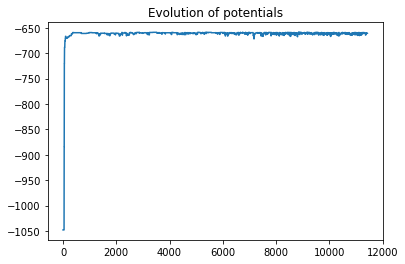

In [72]:
import matplotlib.pyplot as plt
potentials = model.potentials
plt.plot(range(len(potentials)), potentials)
plt.title('Evolution of potentials')
plt.show()

In [73]:
def plot_distance(p_list, p_true):
    n, K = np.shape(p_list)
    d = np.zeros(n)
    for i in range(n):
        d[i] = np.linalg.norm(p_list[i,:] - p_true)
    import matplotlib.pyplot as plt
    plt.plot(range(n), d)
    plt.title('Distance of current p with truth over iterations')

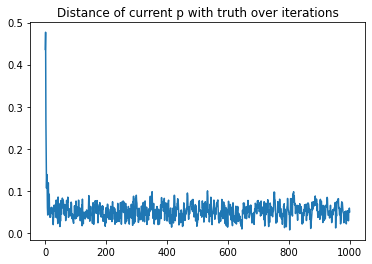

In [74]:
plot_distance(model.p_list, p_true)